In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from scipy.stats import dirichlet, norm, uniform, bernoulli, beta
import timeit
from itertools import permutations 
import itertools
from scipy.special import digamma

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import import_ipynb
np.random.seed(seed=1)

from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import normalize

In [2]:
%run Simulate_data.ipynb
%run Simple_structure.ipynb
%run VI.ipynb
%run VLAD.ipynb

In [3]:
N = 200
L = 500
Q0 = [.6, .25, .15]

In [4]:
X, q_true = simulate_data(N, L, Q0)

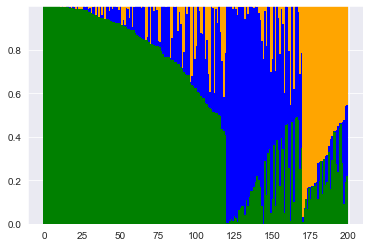

In [5]:
sorted_ind = reorder(q_true)
colors = ['green','blue','orange','red']
ax1 = bar_plot(q_true, sorted_ind, colors)

## Simple STRUCTURE model (paper 2000)

In [6]:
β = 1
γ = 1
α = .5
σ_α = .1
K = 3

In [7]:
θ, q, Z = sample_prior()

In [8]:
## burn-in
start_structure = timeit.default_timer()
for _ in range(1000):
    θ, q, Z, α = Gibbs_next(θ, q, Z, α)

In [9]:
## collect posterior data
qs = []
for _ in range(1000):
    θ, q, Z, α = Gibbs_next(θ, q, Z, α)
    if _ % 10 == 0:
        qs.append(q)
end_structure = timeit.default_timer()
print(end_structure - start_structure)

-5101.272206


In [10]:
qs = np.array(qs)
q_structure = np.mean(qs, axis=0)

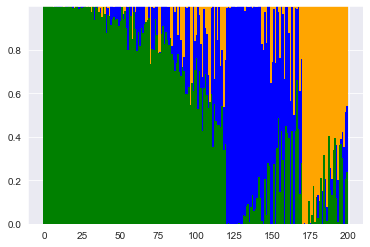

In [37]:
bar_plot(q_structure, sorted_ind, colors, switch_label=[2,1,0])

In [40]:
q_structure_reind = q_structure[:,[2,1,0]]

## Variational Inference

In [66]:
Qold = uniform(0.5, 1.5).rvs((N, K))
Pu = uniform(0.5, 1.5).rvs((K, L))
Pv = uniform(0.5, 1.5).rvs((K, L))
Z = uniform(0.5, 1.5).rvs(size=(N, L, K))
β = 1
γ = 1
α = np.array([0.3] * K)

In [67]:
start_VI = timeit.default_timer()
for _ in range(50):
    Z, Qnew, Pu, Pv = update(Z, Qold, Pu, Pv)
#     if np.linalg.norm(Qnew - Qold) < 1e-8:
#         print(_)
#         break
#     else:
    Qold = Qnew
stop_VI = timeit.default_timer()
print(stop_VI - start_VI)

130.55938320000132


In [68]:
q_VI = normalize(Qnew, norm='l1', axis=1)

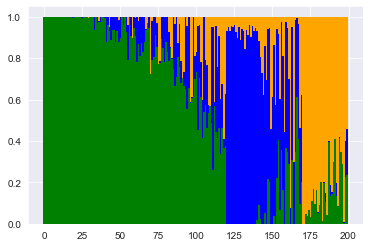

In [71]:
bar_plot(q_VI, sorted_ind, colors, switch_label=[2,0, 1])

In [72]:
q_VI_reind = q_VI[:, [2,0, 1]]

## VLAD

In [16]:
start_VLAD = timeit.default_timer()
θ = VLAD(X, K)
print(timeit.default_timer() - start_VLAD)

9.032703900000342


In [17]:
q_VLAD = admix_prop(X, θ)

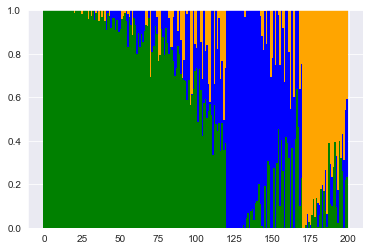

In [48]:
ax2 = bar_plot(q_VLAD, sorted_ind, colors)

In [49]:
q_VLAD_reind = q_VLAD

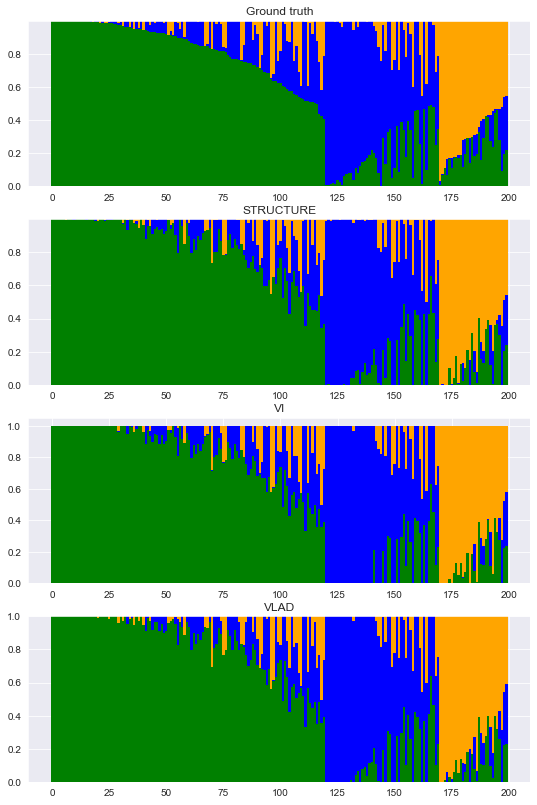

In [50]:
qs = [q_true, q_structure_reind, q_VI_reind, q_VLAD_reind]
titles = ['Ground truth', 'STRUCTURE', 'VI', 'VLAD']
several_bar_plot(qs, sorted_ind, colors, (9,14), titles)

In [73]:
err_STRUCTURE = np.sqrt(np.linalg.norm(q_true - q_structure_reind) / (N*K))
time_STRUCTURE = '1 hour 20 minutes'
err_VI = np.sqrt(np.linalg.norm(q_true - q_VI_reind)/ (N*K))
time_VI = '2 minute 10 seconds'
err_VLAD = np.sqrt(np.linalg.norm(q_true - q_VLAD_reind)/ (N*K))
time_VLAD = '9 seconds'

In [74]:
df = pd.DataFrame({'RMSE': [err_STRUCTURE, err_VI, err_VLAD],
                  'Running time': [time_STRUCTURE, time_VI, time_VLAD]})

In [75]:
df

,RMSE,Running time
0,0.049881,1 hour 20 minutes
1,0.060580,1 minute 20 seconds
2,0.050747,9 seconds
